# Data Challenge for Insight Health Data Science

Pricing optimzation

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Exploration

#### Let's look at the results tables

In [2]:
results_df = pd.read_csv('test_results.csv')

In [3]:
results_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
results_df.describe()

,user_id,test,price,converted
count,316800.000000,316800.000000,316800.000000,316800.000000
mean,499281.341840,0.360079,46.205051,0.018333
std,288591.154044,0.480024,9.601487,0.134154
min,3.000000,0.000000,39.000000,0.000000
25%,249525.750000,0.000000,39.000000,0.000000
50%,499021.500000,0.000000,39.000000,0.000000
75%,749025.500000,1.000000,59.000000,0.000000
max,1000000.000000,1.000000,59.000000,1.000000


In [5]:
results_df.isnull().any()

user_id             False
timestamp           False
source              False
device              False
operative_system    False
test                False
price               False
converted           False
dtype: bool

No missing data

Does the test column match the price column?

In [6]:
results_df.groupby(['test','price']).count()

user_id  timestamp  source  device  operative_system  converted
test price                                                                 
0    39      202517     202517  202517  202517            202517     202517
     59         210        210     210     210               210        210
1    39         155        155     155     155               155        155
     59      113918     113918  113918  113918            113918     113918

There seems to be some mistakes.

Let's eliminate these users for the time being.

In [7]:
inds= ( (results_df.test==0) & (results_df.price==39) ) | ( (results_df.test==1) & (results_df.price==59) )

new_results_df = results_df[inds]

In [8]:
temp_df= new_results_df.groupby('test').converted.count()

temp_df

test
0    202517
1    113918
Name: converted, dtype: int64

In [9]:
temp_df= new_results_df.groupby('test').converted.count()/len(new_results_df)
temp_df

test
0    0.639996
1    0.360004
Name: converted, dtype: float64

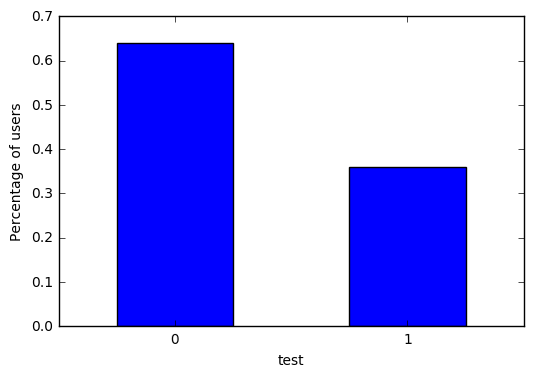

In [10]:
temp_df.plot(kind='bar', rot=True)
plt.ylabel('Percentage of users')

Seems like roughly 1/3 of the users have been selected for the test price

For how long has the test been going on?

In [11]:
np.sort(results_df.timestamp)

array(['2015-03-02 00:04:12', '2015-03-02 00:04:12', '2015-03-02 00:12:40',
       ..., '2015-05-31 23:54:60', '2015-05-31 23:54:60',
       '2015-05-31 23:59:45'], dtype=object)

Seems like the test went on from March 2nd, 2015 until May 31st, 2015

Is there any variation with the different days or times?

First we need to correct the timestamps

In [56]:
def extract_timestamp(ser):
    year=[]
    month=[]
    day=[]
    hour=[]
    minute=[]
    second=[]
    for u in ser:
        date,time= u.split()

        try:
            ye,mo,da= map(np.int, date.split('-'))
            ho,mi,se= map(np.int, time.split(':'))
        except:
            print 'Error with timestamp: %s' % u

        year.append(ye)
        month.append(mo)
        day.append(da)
        hour.append(ho)
        minute.append(mi)
        second.append(se)
    return np.transpose([year,month,day,hour,minute,second])

In [94]:
times= extract_timestamp(new_results_df.timestamp)

In [58]:
# Year
np.unique(times[:,0]).squeeze()

array(2015)

In [59]:
# Month
np.unique(times[:,1]).squeeze()

array([3, 4, 5])

In [60]:
# Day
np.unique(times[:,2]).squeeze()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [61]:
# Hour
np.unique(times[:,3]).squeeze()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [62]:
# Minutes
np.unique(times[:,4]).squeeze()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

In [63]:
# Seconds
np.unique(times[:,5]).squeeze()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

Seconds and minutes are counted from 1 to 60

Let's correct this

In [80]:
def correct_timestamp(times):
    for u in times:
        if u[5]>=60:
            u[4] += 1
            u[5]= u[5]-60
        if u[4]>=60:
            u[3] += 1
            u[4]= u[4]-60
        if u[3]>=24:
            u[2] += 1
            u[3]= u[3]-24
        if (u[2]>=32) & (u[1] in [1,3,5,7,8,10,12]):
            u[1] += 1
            u[2] = u[2] - 31
        if (u[2]>=31) & (u[1] in [4,6,9,11]):
            u[1] += 1
            u[2] = u[2] - 30
        if (u[2]>=29) & (u[1] in [2]):
            u[1] += 1
            u[2] = u[2] - 28
        if u[1]>=13:
            u[0] += 1
            u[1] = u[1] - 12

    return times

In [95]:
times= correct_timestamp(times)

In [85]:
new_results_df['year']= times.T[0]
new_results_df['month']= times.T[1]
new_results_df['day']= times.T[2]
new_results_df['hour']= times.T[3]
new_results_df['minute']= times.T[4]
new_results_df['second']= times.T[5]

/home/joao/anaconda2/envs/insight/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/joao/anaconda2/envs/insight/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/joao/anaconda2/envs/insight/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [100]:
new_results_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,year,month,day,hour,minute,second
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015,5,8,3,38,34
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015,5,10,21,8,46
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015,4,4,15,1,23
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015,5,7,7,26,1
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015,5,24,11,4,40


In [114]:
def combine_timestamp(times):
    timestamps=[]
    for u in times:
        date= '-'.join(map(np.str,u[:3]))
        time= ':'.join(map(np.str,u[3:]))
        timestamps.append(' '.join([date,time]))
    return pd.to_datetime(timestamps)

In [115]:
newtimes= combine_timestamp(times)

In [121]:
new_results_df['day_of_week']= newtimes.dayofweek

/home/joao/anaconda2/envs/insight/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [127]:
new_results_df.drop('timestamp',axis=1,inplace=True)

/home/joao/anaconda2/envs/insight/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [128]:
new_results_df.head()

,user_id,source,device,operative_system,test,price,converted,year,month,day,hour,minute,second,day_of_week
0,604839,ads_facebook,mobile,iOS,0,39,0,2015,5,8,3,38,34,4
1,624057,seo-google,mobile,android,0,39,0,2015,5,10,21,8,46,6
2,317970,ads-bing,mobile,android,0,39,0,2015,4,4,15,1,23,5
3,685636,direct_traffic,mobile,iOS,1,59,0,2015,5,7,7,26,1,3
4,820854,ads_facebook,web,mac,0,39,0,2015,5,24,11,4,40,6


Time influence on the conversion rate

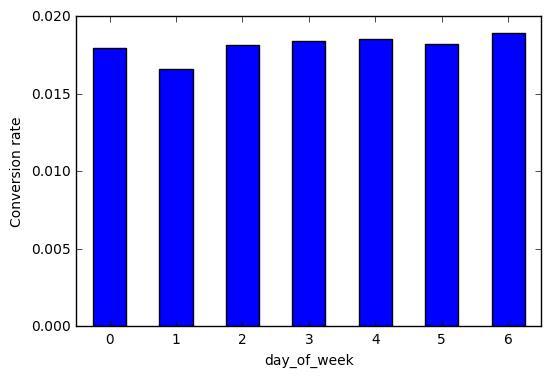

In [132]:
new_results_df.groupby('day_of_week').converted.apply(np.mean).plot(kind='bar',rot=True)
plt.ylabel('Conversion rate')

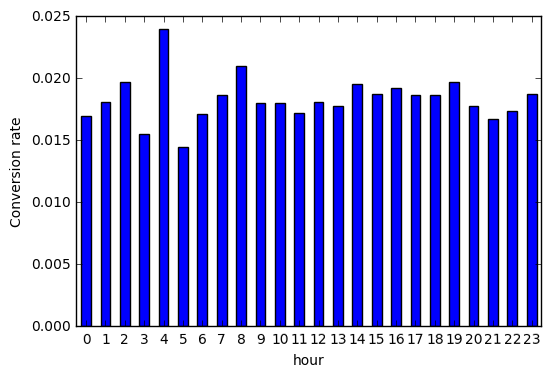

In [134]:
new_results_df.groupby('hour').converted.apply(np.mean).plot(kind='bar',rot=True)
plt.ylabel('Conversion rate')

Device influence on the conversion rate

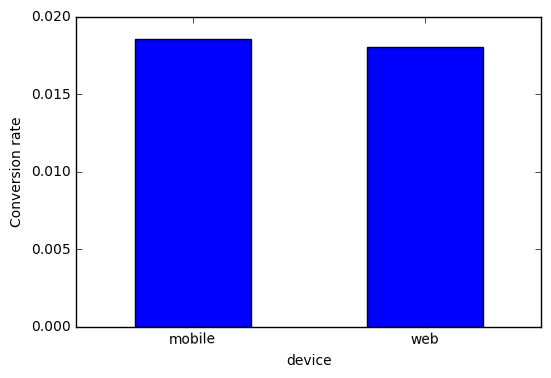

In [136]:
new_results_df.groupby('device').converted.apply(np.mean).plot(kind='bar',rot=True)
plt.ylabel('Conversion rate')

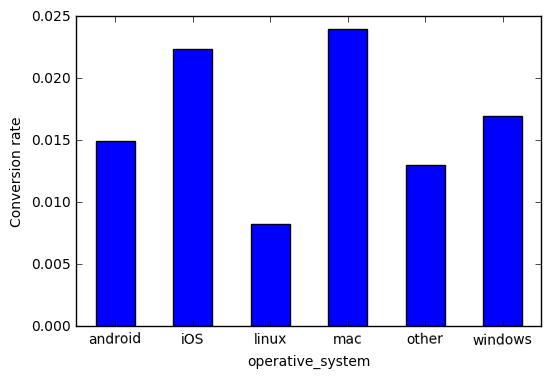

In [138]:
new_results_df.groupby('operative_system').converted.apply(np.mean).plot(kind='bar',rot=True)
plt.ylabel('Conversion rate')

Source influence on the conversion rate

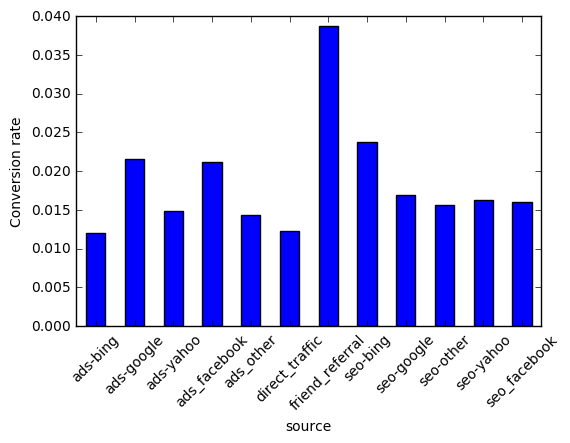

In [141]:
new_results_df.groupby('source').converted.apply(np.mean).plot(kind='bar',rot=45)
plt.ylabel('Conversion rate')

#### Let's look at the user table

In [143]:
user_df= pd.read_csv('user_table.csv')
user_df.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [144]:
user_df.describe()

,user_id,lat,long
count,275616.000000,275616.000000,275616.000000
mean,499245.801521,37.111680,-93.981772
std,288533.458944,5.209627,18.086486
min,3.000000,19.700000,-157.800000
25%,249544.500000,33.660000,-112.200000
50%,498861.000000,37.740000,-88.930000
75%,748856.500000,40.700000,-78.910000
max,999999.000000,61.180000,30.310000


In [145]:
user_df.isnull().any()

user_id    False
city       False
country    False
lat        False
long       False
dtype: bool

No values are missing

In [147]:
user_df.country.unique().squeeze()

array('USA', dtype=object)

Everyone is from the USA!

Let's get the state and regional data of the user

In [195]:
import requests, json

In [196]:
def get_local_info(lat,lon):
    url= 'http://data.fcc.gov/api/block/find?format=json&latitude=%s&longitude=%s' % (np.str(lat),np.str(lon))
    response= requests.get(url)
    temp= json.loads(response.text)
#     time.sleep(0.1)

#     temp['County']['FIPS']
#     temp['County']['name']
#     temp['State']['FIPS']
    return temp['State']['code']
#     temp['State']['name']

In [217]:
for i,u in user_df[:5].iterrows():
    print u.lat, u.long

42.53 -70.97
39.54 -119.82
34.11 -117.39
39.15 -119.74
41.84 -87.68


In [199]:
# This function takes a considerable amount of time
state_code= []
for i,u in user_df.iterrows():
    state_code.append(get_local_info(u.lat,u.long))

KeyboardInterrupt: 

In [201]:
def region_from_state(code):
    if code in ['CT', 'ME', 'MA', 'NH', 'RI', 'VT']:
#         region= 'new_england'
        region= 'northeast'
    elif code in ['NJ', 'NY', 'PA']:
#         region= 'mid_atlantic'
        region= 'northeast'

    elif code in ['IL', 'IN', 'MI', 'OH', 'WI']:
        region= 'midwest'
    elif code in ['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']:
        region= 'midwest'

    elif code in ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV']:
        region= 'south'
    elif code in ['AL', 'KY', 'MS', 'TN']:
        region= 'south'
    elif code in ['AR', 'LA', 'OK', 'TX']:
            region= 'south'

    elif code in ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY']:
        region= 'west'
    elif code in ['AK', 'CA', 'HI', 'OR', 'WA']:
        region= 'west'

Not enough time for this, let's do a simple geometric conversion

In [222]:
region= []
for i,u in user_df.iterrows():
    if u.long < -104.:
        reg= 'west'
    else:
        if u.lat < 37.:
            reg= 'south'
        else:
            if u.long < -80:
                reg= 'midwest'
            else:
                reg= 'northeast'
    region.append(reg)

In [223]:
user_df['region']= region

In [224]:
user_df.head()

,user_id,city,country,lat,long,region
0,510335,Peabody,USA,42.53,-70.97,northeast
1,89568,Reno,USA,39.54,-119.82,west
2,434134,Rialto,USA,34.11,-117.39,west
3,289769,Carson City,USA,39.15,-119.74,west
4,939586,Chicago,USA,41.84,-87.68,midwest


# Feature Engineering

Let's merge both datasets

In [219]:
new_results_df.columns

Index([u'user_id', u'source', u'device', u'operative_system', u'test',
       u'price', u'converted', u'year', u'month', u'day', u'hour', u'minute',
       u'second', u'day_of_week'],
      dtype='object')

In [220]:
user_df.columns

Index([u'user_id', u'city', u'country', u'lat', u'long'], dtype='object')

In [227]:
data_df= pd.merge(new_results_df,user_df,how='inner',on='user_id')
data_df.head()

,user_id,source,device,operative_system,test,price,converted,year,month,day,hour,minute,second,day_of_week,city,country,lat,long,region
0,604839,ads_facebook,mobile,iOS,0,39,0,2015,5,8,3,38,34,4,Buffalo,USA,42.89,-78.86,northeast
1,624057,seo-google,mobile,android,0,39,0,2015,5,10,21,8,46,6,Lakeville,USA,44.68,-93.24,midwest
2,317970,ads-bing,mobile,android,0,39,0,2015,4,4,15,1,23,5,Parma,USA,41.38,-81.73,midwest
3,685636,direct_traffic,mobile,iOS,1,59,0,2015,5,7,7,26,1,3,Fayetteville,USA,35.07,-78.90,south
4,820854,ads_facebook,web,mac,0,39,0,2015,5,24,11,4,40,6,Fishers,USA,39.95,-86.02,midwest


Let's convert categorical variables into binary responses

In [235]:
print data_df.source.unique()



['ads_facebook' 'seo-google' 'ads-bing' 'direct_traffic' 'ads-google'
 'friend_referral' 'ads_other' 'ads-yahoo' 'seo-yahoo' 'seo_facebook'
 'seo-bing' 'seo-other']
['mobile' 'web']
['iOS' 'android' 'mac' 'windows' 'other' 'linux']


In [241]:
print data_df.device.unique()

['mobile' 'web']


In [240]:
temp_vals= []
for i,u in data_df.iterrows():
    if u.device == 'mobile':
        temp_vals.append(1)
    elif u.device == 'web':
        temp_vals.append(0)
    else:
        print 'ERROR: row has no recognized device', u

In [242]:
data_df['mobile']= temp_vals

In [246]:
data_df.loc[:,['device','mobile']].head()

,device,mobile
0,mobile,1
1,mobile,1
2,mobile,1
3,mobile,1
4,web,0


In [249]:
temp_cols= data_df.operative_system.unique()
print temp_cols

['iOS' 'android' 'mac' 'windows' 'other' 'linux']


In [251]:
for col in temp_cols:
    temp_vals=[]
    for i,u in data_df.iterrows():
        if u.operative_system == col:
            temp_vals.append(1)
        else:
            temp_vals.append(0)
    data_df[col]= temp_vals

In [262]:
data_df.loc[:,np.concatenate([['operative_system'],temp_cols])].head()

,operative_system,iOS,android,mac,windows,other,linux
0,iOS,1,0,0,0,0,0
1,android,0,1,0,0,0,0
2,android,0,1,0,0,0,0
3,iOS,1,0,0,0,0,0
4,mac,0,0,1,0,0,0


In [263]:
temp_cols= data_df.source.unique()
print temp_cols

['ads_facebook' 'seo-google' 'ads-bing' 'direct_traffic' 'ads-google'
 'friend_referral' 'ads_other' 'ads-yahoo' 'seo-yahoo' 'seo_facebook'
 'seo-bing' 'seo-other']


In [264]:
for col in temp_cols:
    temp_vals=[]
    for i,u in data_df.iterrows():
        if u.source == col:
            temp_vals.append(1)
        else:
            temp_vals.append(0)
    data_df[col]= temp_vals

In [265]:
data_df.loc[:,np.concatenate([['source'],temp_cols])].head()

,source,ads_facebook,seo-google,ads-bing,direct_traffic,ads-google,friend_referral,ads_other,ads-yahoo,seo-yahoo,seo_facebook,seo-bing,seo-other
0,ads_facebook,1,0,0,0,0,0,0,0,0,0,0,0
1,seo-google,0,1,0,0,0,0,0,0,0,0,0,0
2,ads-bing,0,0,1,0,0,0,0,0,0,0,0,0
3,direct_traffic,0,0,0,1,0,0,0,0,0,0,0,0
4,ads_facebook,1,0,0,0,0,0,0,0,0,0,0,0


In [302]:
temp_cols= data_df.region.unique()
print temp_cols

['northeast' 'midwest' 'south' 'west']


In [303]:
for col in temp_cols:
    temp_vals=[]
    for i,u in data_df.iterrows():
        if u.region == col:
            temp_vals.append(1)
        else:
            temp_vals.append(0)
    data_df[col]= temp_vals

In [304]:
data_df.loc[:,np.concatenate([['region'],temp_cols])].head()

,region,northeast,midwest,south,west
0,northeast,1,0,0,0
1,midwest,0,1,0,0
2,midwest,0,1,0,0
3,south,0,0,1,0
4,midwest,0,1,0,0


Combine source data from ads (and seo) into one category

In [266]:
# data_df['ads']=[0]*len(data_df)
# data_df['seo']=[0]*len(data_df)

In [267]:
# for i,u in data_df.iterrows():
#     if u.source[:3]=='ads':
#         data_df['ads']= 1
#     if u.source[:3]=='seo':
#         data_df['seo']= 1 

In [278]:
# data_df.drop('ads',axis=1,inplace=True)
# data_df.drop('seo',axis=1,inplace=True)

In [360]:
temp_vals=[]
for i,u in data_df.iterrows():
    temp_vals.append(u.converted*u.price)
data_df['return']= temp_vals

Let's drop some columns

In [361]:
data_df.head()

,user_id,source,device,operative_system,test,price,converted,year,month,day,...,ads-yahoo,seo-yahoo,seo_facebook,seo-bing,seo-other,northeast,midwest,south,west,return
0,604839,ads_facebook,mobile,iOS,0,39,0,2015,5,8,...,0,0,0,0,0,1,0,0,0,0
1,624057,seo-google,mobile,android,0,39,0,2015,5,10,...,0,0,0,0,0,0,1,0,0,0
2,317970,ads-bing,mobile,android,0,39,0,2015,4,4,...,0,0,0,0,0,0,1,0,0,0
3,685636,direct_traffic,mobile,iOS,1,59,0,2015,5,7,...,0,0,0,0,0,0,0,1,0,0
4,820854,ads_facebook,web,mac,0,39,0,2015,5,24,...,0,0,0,0,0,0,1,0,0,0


In [362]:
data_df= pd.read_csv('data_raw.csv')
# data_df.to_csv('data_raw.csv',index=False,header=True)

In [363]:
cols= data_df.columns
print cols

Index([u'user_id', u'source', u'device', u'operative_system', u'test',
       u'price', u'converted', u'year', u'month', u'day', u'hour', u'minute',
       u'second', u'day_of_week', u'city', u'country', u'lat', u'long',
       u'region', u'mobile', u'iOS', u'android', u'mac', u'windows', u'other',
       u'linux', u'ads_facebook', u'seo-google', u'ads-bing',
       u'direct_traffic', u'ads-google', u'friend_referral', u'ads_other',
       u'ads-yahoo', u'seo-yahoo', u'seo_facebook', u'seo-bing', u'seo-other',
       u'northeast', u'midwest', u'south', u'west', u'return'],
      dtype='object')


In [364]:
price={0:39, 1:59}

In [365]:
cols= [u'user_id', u'test', u'converted', u'return',
       u'hour', u'day_of_week',
       u'northeast', u'midwest', u'south', u'west',
       u'iOS', u'android', u'mac', u'windows', u'other', u'linux',
       u'ads-google', u'ads_facebook', u'ads-bing', u'ads-yahoo', u'ads_other',
       u'seo-google', u'seo_facebook', u'seo-bing', u'seo-yahoo', u'seo-other',
       u'direct_traffic', u'friend_referral']

In [366]:
data_df= data_df[cols]

In [367]:
data_df.head()

,user_id,test,converted,return,hour,day_of_week,northeast,midwest,south,west,...,ads-bing,ads-yahoo,ads_other,seo-google,seo_facebook,seo-bing,seo-yahoo,seo-other,direct_traffic,friend_referral
0,604839,0,0,0,3,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,624057,0,0,0,21,6,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,317970,0,0,0,15,5,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,685636,1,0,0,7,3,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,820854,0,0,0,11,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [368]:
data_df.to_csv('data.csv',index=False,header=True)

# Direct comparison of conversion rates for different prices

In [369]:
inds_lwrprice= (data_df.test==0)
inds_uppprice= (data_df.test==1)

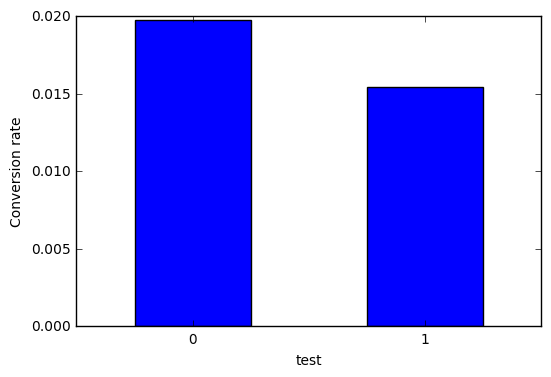

In [370]:
data_df.groupby('test').converted.apply(np.mean).plot(kind='bar',rot=True)
plt.ylabel('Conversion rate')

In [ ]:
# exp_return_df= temp_df*pd.Series(price)

In [380]:
exp_return_df= data_df.groupby('test')['return'].apply(np.mean)

In [381]:
exp_return_df

test
0    0.770967
1    0.911330
Name: return, dtype: float64

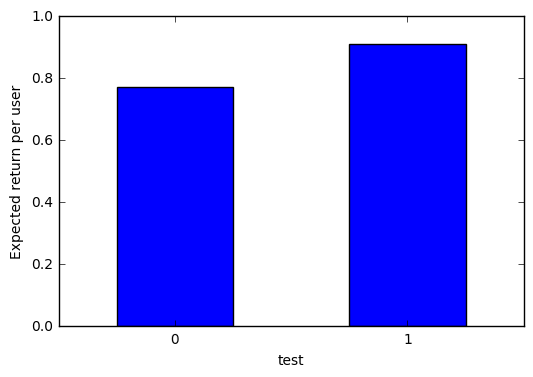

In [382]:
exp_return_df.plot(kind='bar',rot=True)
plt.ylabel('Expected return per user')

Check for statistical significance

In [401]:
N_0= np.sum(inds_lwrprice)
mu_0= data_df.loc[inds_lwrprice,'return'].mean()
std_0= data_df.loc[inds_lwrprice,'return'].std(ddof=1)
err_0= std_0/np.sqrt(N_0)

In [402]:
N_1= np.sum(inds_uppprice)
mu_1= data_df.loc[inds_uppprice,'return'].mean()
std_1= data_df.loc[inds_uppprice,'return'].std(ddof=1)
err_1= std_1/np.sqrt(N_1)

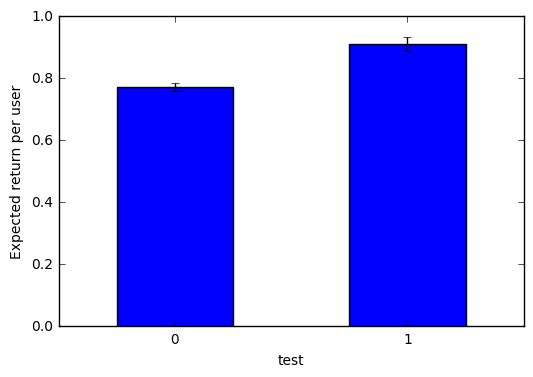

In [405]:
exp_return_df.plot(kind='bar',rot=True,yerr=[err_0,err_1])
plt.ylabel('Expected return per user')

In [406]:
from scipy import stats

In [409]:
t,p= stats.ttest_ind(data_df.loc[inds_lwrprice,'return'], data_df.loc[inds_uppprice,'return'], equal_var=False)
print p

1.16668875157e-07


There is a significant difference

# Exploring the features